In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import normalize
%matplotlib inline

Using TensorFlow backend.


In [9]:
import utilities
df=pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

In [10]:
from descriptor import rdkitDescriptors as rdD

In [14]:
data_train = rdD.batch_compute_rdkit_fingerprints(df['SMILES'])

In [15]:
df.head()

,SMILES,value (% BOD),Salt Stripped Molecule,SMILES (Optimized Geometry),Converged,Energy,SMILES (RDKit Mol),SlogP,SMR,LabuteASA,...,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42,cleaned_bod
0,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,0.0,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,1,-16.47820492,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,0.7004,60.0924,98.199515,...,0,0,2,0,0,0,0,0,0,0.0
1,CC(O)C(O)=O,76.0,CC(O)C(=O)O,CC(O)C(=O)O,1,18.51507187,CC(O)C(O)=O,-0.5482,19.3166,35.219125,...,0,0,0,0,0,0,0,0,0,76.0
2,Clc1ccc(cc1)C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl,0.0,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,1,56.61000444,Clc1ccc(cc1)C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl,6.4955,85.0370,136.734713,...,0,0,2,0,0,0,0,0,0,0.0
3,OC(=O)c1c(Cl)ccc(Cl)c1Cl,1.0,O=C(O)c1c(Cl)ccc(Cl)c1Cl,O=C(O)c1c(Cl)ccc(Cl)c1Cl,1,13.71352211,OC(=O)c1c(Cl)ccc(Cl)c1Cl,3.3450,48.4313,83.661900,...,0,0,1,0,0,0,0,0,0,1.0
4,OCC(O)C(O)C(O)C(O)CO,82.0,OCC(O)C(O)C(O)C(O)CO,OCC(O)C(O)C(O)C(O)CO,1,23.15533611,OCC(O)C(O)C(O)C(O)CO,-3.5854,38.1988,69.329364,...,0,0,0,0,0,0,0,0,0,82.0


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

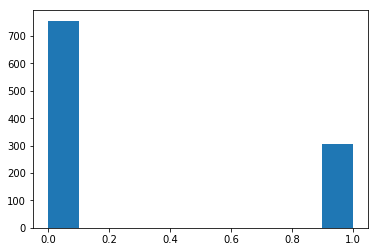

In [84]:
df['bi_class_partition']=utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

(array([535.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 528.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

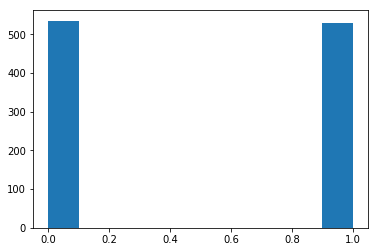

In [78]:
df['bi_class_q50']=pd.qcut(df['cleaned_bod'].values, 2, labels=[0,1])
true_label_q50 = df['bi_class_q50'].values
plt.hist(true_label_q50)

In [100]:
from dimreducer import DeepAutoEncoder
from cluster import KMeansLayer
from keras import Model

In [127]:
dims = [2048,512,128,64]
autoencoder =  DeepAutoEncoder(dims)
autoencoder.build_autoencoder()
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
encoder_0 (Dense)            (None, 512)               1049088   
_________________________________________________________________
encoder_1 (Dense)            (None, 128)               65664     
_________________________________________________________________
embedding_layer (Dense)      (None, 64)                8256      
_________________________________________________________________
decoder_2 (Dense)            (None, 128)               8320      
_________________________________________________________________
decoder_1 (Dense)            (None, 512)               66048     
__________

In [128]:
embeding   = autoencoder.model.get_layer(name='embedding_layer').output
encoder    = Model(inputs=autoencoder.model.input, outputs=embeding)
n_clusters = 2
alpha      = 1.0
clustering = KMeansLayer(n_clusters, alpha=alpha, name='clustering')(embeding)
model      = Model(inputs=autoencoder.model.input, outputs=[clustering,autoencoder.model.output])

In [129]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 2048)         0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 2048)         8192        input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 512)          1049088     batch_normalization_10[0][0]     
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 128)          65664       encoder_0[0][0]                  
__________________________________________________________________________________________________
embedding_

In [130]:
model.compile(loss={'clustering': 'kld', 'decoder_output': 'binary_crossentropy'},
              loss_weights=[0.8, 0.2],optimizer='adam')

In [131]:
from cluster import KMeans

def target_distribution(q):  # target distribution P which enhances the discrimination of soft label Q
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [132]:
kmeans_init = KMeans(n_clusters=2)
kmeans_init.bulid_kmeans_cluster()
kmeans_init.model.fit(encoder.predict(data_train))
y_pred_last = kmeans_init.model.labels_
model.get_layer(name='clustering').set_weights([kmeans_init.model.cluster_centers_])

In [133]:
update_interval = 10
maxiter = 1e4
tol = 1e-4
loss = []
delta_label = []
for iteration in range(int(maxiter)):
    if iteration % update_interval == 0:
        q, _ = model.predict(data_train)
        p = target_distribution(q)
        y_pred = q.argmax(1)
        delta_label_i = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        delta_label.append(delta_label_i)
        y_pred_last = y_pred
    
    if iteration > update_interval and delta_label_i < tol:  
        print(str(delta_label_i) +' < ' + str(tol))
        print('Reached tolerance threshold. Stopping training.')
        break
    
    loss_tmp = model.train_on_batch(x=data_train, y=[p,data_train])
    loss.append(loss_tmp)
    if iteration % update_interval == 0:
        print('Epoch: ' + str(iteration))
        print('total_loss = ' + str(loss_tmp[0]) + '; clustering_loss = ' +
              str(loss_tmp[1]) + '; decoder_loss = ' + str(loss_tmp[2]) + 
              '; delta_label = ' + str(delta_label_i))
    



Epoch: 0
total_loss = 0.2807659; clustering_loss = 0.12407865; decoder_loss = 0.9075148; delta_label = 0.0
Epoch: 10
total_loss = 0.08955149; clustering_loss = 0.024077132; decoder_loss = 0.35144892; delta_label = 0.09877704609595485
Epoch: 20
total_loss = 0.08352908; clustering_loss = 0.027761584; decoder_loss = 0.30659905; delta_label = 0.05644402634054563
Epoch: 30
total_loss = 0.08810866; clustering_loss = 0.039485537; decoder_loss = 0.28260115; delta_label = 0.02539981185324553
Epoch: 40
total_loss = 0.09295961; clustering_loss = 0.046457488; decoder_loss = 0.2789681; delta_label = 0.024459078080903106
Epoch: 50
total_loss = 0.0973477; clustering_loss = 0.05401193; decoder_loss = 0.27069077; delta_label = 0.011288805268109126
Epoch: 60
total_loss = 0.10170095; clustering_loss = 0.060730044; decoder_loss = 0.26558453; delta_label = 0.010348071495766699
Epoch: 70
total_loss = 0.10569604; clustering_loss = 0.06638059; decoder_loss = 0.26295784; delta_label = 0.0018814675446848542
Epo

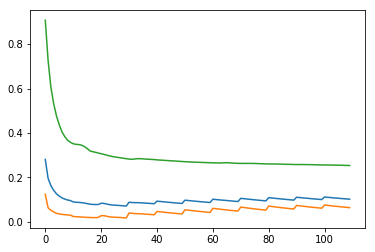

In [134]:
plt.plot(loss)

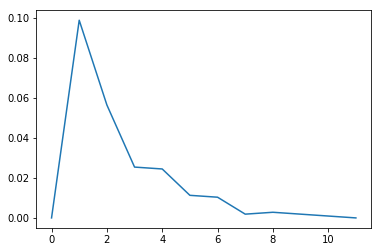

In [135]:
plt.plot(delta_label)

(array([521.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 542.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

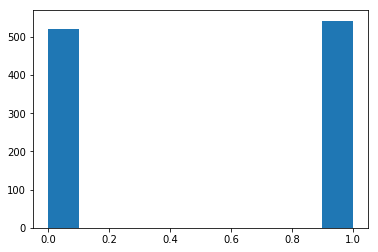

In [136]:
plt.hist(y_pred)

In [137]:
from cluster import Cluster
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: 0.035656247631877816 
adjusted mutual info score: 0.028950018275187783
homogeneity completeness v measure:
(0.034136238038052866, 0.029610358061321434, 0.03171263386667848)
fowlkes_mallows : 0.5588806352205085


/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


{'adjusted_rand_score': 0.035656247631877816,
 'adjusted_mutual_info_score': 0.028950018275187783,
 'homogeneity_completeness_v_measure': (0.034136238038052866,
  0.029610358061321434,
  0.03171263386667848),
 'fowlkes_mallows_score': 0.5588806352205085}

In [138]:
from cluster import Cluster
Cluster.true_label_metrics(true_label_q50,y_pred,print_metric=True)

Metric with True label
adjusted rand score: 0.04551084566551281 
adjusted mutual info score: 0.03305782831804775
homogeneity completeness v measure:
(0.03371493994125138, 0.03372337989668163, 0.033719159390833184)
fowlkes_mallows : 0.5224096071362249


{'adjusted_rand_score': 0.04551084566551281,
 'adjusted_mutual_info_score': 0.03305782831804775,
 'homogeneity_completeness_v_measure': (0.03371493994125138,
  0.03372337989668163,
  0.033719159390833184),
 'fowlkes_mallows_score': 0.5224096071362249}

In [139]:
np.count_nonzero(true_label_biclass == y_pred)

430

In [140]:
np.count_nonzero(true_label_q50 == y_pred)

417

In [141]:
1063 - 430

633